In [1]:
import random
import pandas as pd
import numpy as np
import numpy.linalg as la
import scipy.sparse as sp
import sklearn.preprocessing
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
import itertools
import scipy.sparse.linalg as spla
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix
from scipy.sparse.linalg import lsqr



df = pd.read_csv('user_song.csv')
test_df = pd.read_csv('test.csv')
train_users = df.iloc[:, 0].unique().tolist()
train_songs = df.iloc[:, 1].unique().tolist()
train_couples = list(zip(df.iloc[:, 0], df.iloc[:, 1]))

test_users = test_df.iloc[:, 0].unique().tolist()
test_songs = test_df.iloc[:, 1].unique().tolist()
test_couples = list(zip(test_df.iloc[:, 0], test_df.iloc[:, 1]))

all_users = list(set(train_users + test_users))
all_songs = list(set(train_songs + test_songs))
all_couples = list(itertools.product(all_users, all_songs))
new_couples = list(set(all_couples) - set(train_couples) - set(test_couples))

In [82]:
attempt = pd.read_csv('user_song.csv')

In [83]:
from sklearn.model_selection import KFold
cross_validation = KFold(n_splits=2)
for t,tst, in cross_validation.split(attempt):
    train,test = attempt[t],attempt[tst]
    print(train)
    break

AttributeError: module 'numpy' has no attribute 'int'

# Part 1 - Least Squares

In [2]:
n = df.shape[0]
m = n + len(new_couples)
avg = df.iloc[:, 2].mean()
avg

733.3121758765291

In [3]:
num_users = len(all_users)  # Number of users
num_songs = len(all_songs)  # Number of songs
num_songs, num_users

(17932, 4865)

In [60]:
all_users

[655360,
 0,
 1,
 3,
 4,
 5,
 950278,
 6,
 7,
 204809,
 8,
 9,
 720908,
 10,
 303118,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 466968,
 20,
 335898,
 21,
 753692,
 22,
 23,
 24,
 25,
 548897,
 26,
 27,
 90148,
 983077,
 32806,
 835622,
 31,
 32,
 33,
 34,
 35,
 32813,
 614445,
 38,
 39,
 40,
 41,
 42,
 32820,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 352318,
 54,
 55,
 352321,
 57,
 58,
 59,
 60,
 540742,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 131162,
 82,
 827484,
 811101,
 85,
 86,
 87,
 88,
 89,
 770147,
 91,
 92,
 93,
 147559,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 303215,
 103,
 104,
 105,
 106,
 819316,
 108,
 109,
 802935,
 111,
 112,
 113,
 114,
 115,
 116,
 983166,
 118,
 119,
 120,
 121,
 122,
 123,
 204933,
 680069,
 843911,
 950407,
 128,
 129,
 130,
 131,
 28,
 133,
 134,
 135,
 145,
 721041,
 29,
 139,
 140,
 141,
 180375,
 30,
 144,
 146,
 147,
 148,
 149,
 150,
 196767,
 229536,
 152,
 688290,
 958627,
 15

In [66]:
# user dictionary
users_hash = {}
for i, user in enumerate(all_users):
    if user == 6135:
        print(i)
    users_hash[user] = i

4221


In [54]:
# song dictionary
songs_hash = {}
for j, song in enumerate(all_songs):
    songs_hash[song] = j + num_users

In [73]:
import pandas as pd

attempt = pd.DataFrame({'row_num': [ 1, 2, 2, 3,1,3],
                   'col_num': [ 'B', 'A', 'B', 'B','A','A'],
                   'value': [10, 20, 30, 40, 50, 60]})
attempt.pivot(index='row_num', columns='col_num', values='value').to_numpy()

array([[50, 10],
       [20, 30],
       [60, 40]], dtype=int64)

## creating the A and c
\begin{equation}
\hat{b} = \arg\min_{b} \|Ab - c\|^2
\end{equation}

In [6]:
train_users, train_songs = df['user_id'].map(users_hash).values, df['song_id'].map(songs_hash).values
merged_train = np.column_stack((train_users, train_songs)).reshape(-1)
A_cols = merged_train

In [7]:
rows1, rows2 = np.arange(int(0.5 * len(A_cols))), np.arange(int(0.5 * len(A_cols)))
A_rows = np.column_stack((rows1, rows2)).reshape(-1)

In [8]:
values = np.ones(len(A_rows))

In [9]:
A = coo_matrix((values, (A_rows, A_cols)),
               shape=(int(0.5 * len(A_cols)), len(all_users) + len(all_songs))).tocsr()
c = df['weight'].values - avg

## Ls

In [10]:
final_b = lsqr(A=A, b=c)
final_b = final_b[0]
b_u_hat = final_b[:num_users]
b_i_hat = final_b[num_users:]

## true matrix

In [11]:
songs_hash = {}
for j, song in enumerate(all_songs):
    songs_hash[song] = j

In [12]:
values = df['weight'].values
rows = df['user_id'].map(users_hash).values
cols = df['song_id'].map(songs_hash).values
true_mat = coo_matrix((values, (rows, cols)), shape=(num_users, num_songs)).tocsr()

In [13]:
predictions_part1 = true_mat.tolil(copy=True)
for tup in zip(rows, cols):
    user, song = tup[0], tup[1]
    predictions_part1[tup] = max(avg + b_u_hat[user] + b_i_hat[song], 0)
predictions_part1 = predictions_part1.tocsr()

## Train scores - part 1

In [14]:
def get_score(true, pred, N, arr_type='np'):
    score_matrix = (true - pred)
    if arr_type == 'sp':
        score_matrix = score_matrix.toarray()
    return {'SSE': la.norm(score_matrix) ** 2, 'RMSE': ((la.norm(score_matrix) ** 2) / N) ** 0.5}

In [15]:
N = df.shape[0]
scores_part1 = get_score(true_mat, predictions_part1, N, arr_type='sp')
print(f'RMSE in Part 1 on train set: {scores_part1["RMSE"]}\n'
      f'SSE in Part 1 on train set: {scores_part1["SSE"]}')

RMSE in Part 1 on train set: 3392.5561369842526
SSE in Part 1 on train set: 927683652567.0001


## Test Prediction - part 1

In [16]:
test_users_mapped = test_df['user_id'].map(users_hash).values
test_songs_mapped = test_df['song_id'].map(songs_hash).values
test_indxs_mapped = list((zip(test_users_mapped, test_songs_mapped)))

In [17]:
test_pred_1 = []
for idx in test_indxs_mapped:
    user, song = idx[0], idx[1]
    test_pred_1.append(max(avg + b_u_hat[user] + b_i_hat[song], 0))

In [39]:
test_df['predictions'] = test_pred_1
test_df.to_csv('C:\\Users\hadar\Documents\semester 5\ecommerce\Ecommerce_HW3\\206567067_318880754_task1.csv',index=False)
test_df = test_df.drop('predictions', axis=1)

# Part 2 - ALS Method

In [18]:
# user dictionary
users_hash = {}
for i, user in enumerate(all_users):
    users_hash[user] = i

In [19]:
# song dictionary
songs_hash = {}
for j, song in enumerate(all_songs):
    songs_hash[song] = j

In [20]:
num_users = len(all_users)  # Number of users
num_songs = len(all_songs)  # Number of songs
num_users, num_songs

(4865, 17932)

## create the ratings matrix

In [21]:
# scaler = MinMaxScaler(feature_range=(0, 100))
values = df['weight'].values
rows = df['user_id'].map(users_hash).values
cols = df['song_id'].map(songs_hash).values
true_mat = coo_matrix((values, (rows, cols)), shape=(num_users, num_songs)).tocsr()
mat_part2 = true_mat.toarray()

## ALS model

In [22]:
# alternating least squares step
def als_step(latent_vectors, fixed_vecs, ratings, _lambda=0, type='user'):
    """
    One of the two ALS steps. Solve for the latent vectors
    specified by type.
    """
    if type == 'user':
        # calculating P, Q is fixed
        for u in range(latent_vectors.shape[0]):  # iterate over P rows and R Rows
            r = ratings[u, :].flatten()
            rows_to_remove = np.where(r==0)[0]
            clean_r = np.delete(r, rows_to_remove)
            mat = np.delete(fixed_vecs, rows_to_remove, axis=0)
            latent_vectors[u, :] = la.lstsq(mat, clean_r,rcond=None)[0]
    elif type == 'item':
        # calculating Q, P is fixed
        for i in range(latent_vectors.shape[0]):
            # remove rows from
            r = ratings[:, i].flatten()
            rows_to_remove = np.where(r==0)[0]
            clean_r = np.delete(r, rows_to_remove)
            mat = np.delete(fixed_vecs, rows_to_remove, axis=0)

            latent_vectors[i, :] = la.lstsq(mat,clean_r,rcond=None)[0]
    return latent_vectors

In [23]:
def als_predict_vecs(k=20,eps=300000):
    np.random.seed(0)
    new_songs = np.zeros((num_songs, k))
    new_users = np.random.randn(num_users,k)
    scores_array = list()
    start = True
    i=1
    while start or (scores_array[-2]['SSE'] - scores_array[-1]['SSE']>=eps) :
        new_songs = als_step(new_songs,
                             new_users,
                             mat_part2,
                             type='item')
        # new_songs = np.maximum(new_songs, 0)
        new_users = als_step(new_users,
                             new_songs,
                             mat_part2,
                             type='user')
        meantime_pred = predict(new_users, new_songs)
        meantime_pred = np.maximum(meantime_pred, 0)
        scores_array.append(get_score(mat_part2, meantime_pred, N))
        i+=1
        if i ==3:
            start = False
    return new_users, new_songs, scores_array


In [24]:
# user_matrix,song_matrix = als_predict()
def predict(users, songs):
    predictions = np.matmul(users, songs.T)
    train_indices = list(zip(rows,cols))
    mask = np.zeros(predictions.shape,dtype=bool)
    for entry in train_indices:
        mask[entry]=True
    predictions[~mask] = 0
    return predictions

## Train Prediction - part 2

In [25]:
user_vecs, song_vecs, scores_arr = als_predict_vecs()
scores_part2 = scores_arr[-1]['SSE']
print(f'RMSE in Part 2 on train set: {scores_part2}\n'
      f'SSE in Part 2 on train set: {scores_part2}\n'
      f'compared to part 1\n'
      f'Improvement of {scores_part1["RMSE"] - scores_arr[-1]["RMSE"]} in the RMSE\n'
      f'Improvement of {scores_part1["SSE"] - scores_part2} in the SSE')

RMSE in Part 2 on train set: 265318262.21470994
SSE in Part 2 on train set: 265318262.21470994
compared to part 1
Improvement of 3335.1827269960277 in the RMSE
Improvement of 927418334304.7854 in the SSE


## check the learning curve

In [26]:
RMSE_curve = [d['RMSE'] for d in scores_arr]
SSE_curve = [d['SSE'] for d in scores_arr]

In [27]:
RMSE_curve

[916.6367700468096,
 311.3889005460519,
 223.0734839234272,
 189.74628386869946,
 171.10659798881616,
 158.40272245353816,
 148.82906293301804,
 141.32628381443067,
 135.33675369912538,
 130.4613491226145,
 126.40809191799701,
 122.98010222038916,
 120.01491804299413,
 117.39848414780279,
 115.02434268887822,
 112.88705470121054,
 110.94150169979136,
 109.15664944166473,
 107.51653318991886,
 105.99762697146902,
 104.57875174407711,
 103.25477724785063,
 102.0160836932486,
 100.86130139134089,
 99.78034458473067,
 98.76074911161527,
 97.79546044701272,
 96.87942796732848,
 96.00866711386821,
 95.18284100038817,
 94.39902448725324,
 93.64695216055476,
 92.92938308440591,
 92.24299298150339,
 91.5852342425693,
 90.95540187234424,
 90.35159936421994,
 89.77143555798385,
 89.21281898737264,
 88.67491150919136,
 88.15577939606955,
 87.6544467692365,
 87.1671144735557,
 86.69353259079266,
 86.23424484553914,
 85.78793433121477,
 85.35408501647069,
 84.93167353934905,
 84.51964270568254,
 84.

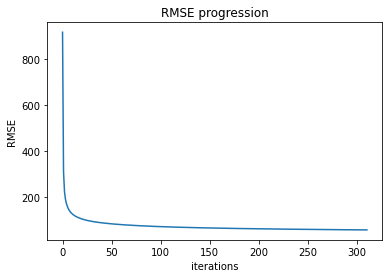

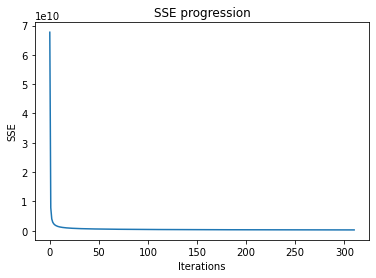

In [28]:
# Plotting list1
plt.figure(1)
plt.plot(np.arange(len(RMSE_curve)),RMSE_curve)
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.title('RMSE progression')

# Plotting list2
plt.figure(2)
plt.plot(np.arange(len(RMSE_curve)),SSE_curve)
plt.xlabel('Iterations')
plt.ylabel('SSE')
plt.title('SSE progression')

# Show the plots
plt.show()

## Test Prediction - part 2

In [29]:
test_pred_2 = []
for idx in test_indxs_mapped:
    user, song = idx[0], idx[1]
    user_vec, song_vec = user_vecs[user], song_vecs[song]
    pred = user_vec.dot(song_vec)
    test_pred_2.append(max(pred, 0))

In [44]:
test_df['predictions'] = test_pred_2
test_df.to_csv('206567067_318880754_task2.csv',index=False)
test_df = test_df.drop('predictions', axis=1)

# Part 3

In [30]:
# Perform SVD on the sparse matrix
# k = Number of singular values/vectors to use
U, S, V = svds(true_mat.astype(float), k=20)

# Reconstruct the matrix using k singular values/vectors
reduced_R = U.dot(sp.diags(S).dot(V))

## part 3 train scores

In [31]:
predictions = reduced_R
train_indices = list(zip(rows,cols))
mask = np.zeros(reduced_R.shape,dtype=bool)
for entry in train_indices:
    mask[entry]=True
predictions[~mask] = 0
score = get_score(true_mat.toarray(),predictions,N)

## part 3 - test

In [32]:
test_pred_3 = []
for idx in test_indxs_mapped:
    user, song = idx[0], idx[1]
    test_pred_3.append(max(reduced_R[user,song], 0))

In [33]:
score['SSE']-235000000000

-5731609340.201843

In [34]:
test_pred_3 = []
for i, row in test_df.iterrows():
    user = row['user_id']
    song = row['song_id']
    user_index = users_hash[user]
    song_index = songs_hash[song]
    test_pred_3.append(max(reduced_R[user_index, song_index], 0))

In [45]:
test_df['predictions'] = test_pred_3
test_df.to_csv('206567067_318880754_task3.csv',index=False)
test_df = test_df.drop('predictions', axis=1)